<a href="https://colab.research.google.com/github/IhorTkachMykol/first/blob/main/Learning_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Навчання Deep Convolutional Generative Adversarial Network (DCGAN) на завантажених даних Cifar

## Завантаження і попередня підготовка Дата-сетів

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Зчитування мета-даних та суперкласів

Посилання на дані

In [ ]:
URL_DIR = "https://www.cs.toronto.edu/~kriz/"
# FILE_NAME_CIFAR_10 = "cifar-10-python.tar.gz"
FILE_NAME_CIFAR_100 = "cifar-100-python.tar.gz"

Завантажимо дані

In [ ]:
def load_and_unzip_cifar(url:str, file_name:str):
  '''Завантаження і розпакування файлу-архіву, якщо ще цього не зроблено'''
  # Завантаження даних
  from pathlib import Path
  full_url_to_load = url + file_name
  print(full_url_to_load)
  if Path(file_name).exists() and Path(file_name).is_file():
    print(f"Файл {file_name} вже є. Немає потреби його завантажувати!")
  else:
    print(f"Заватажуємо файл {file_name} ")
    !wget $full_url_to_load
  # Розпакування даних
  # Створення робочої папки через stem i split - відсікання суфіксів
  work_dir = Path(str((Path() / Path(file_name).stem)).split(".")[0])
  # print(work_dir)
  if work_dir.exists() and work_dir.is_dir():
    print(f"Директорія {work_dir} вже існує, перезаписуємо файли")
    # Перезаписуємо, бо є файл *txt, який не дає видалити папку
    !tar -xzvf $file_name
  else:
    print(f"Розпакуємо файл {file_name}")
    !tar -xzvf $file_name

load_and_unzip_cifar(URL_DIR, FILE_NAME_CIFAR_100)

https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Заватажуємо файл cifar-100-python.tar.gz 
--2024-07-19 18:15:51--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  93.1MB/s    in 1.7s    

2024-07-19 18:15:53 (93.1 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

Розпакуємо файл cifar-100-python.tar.gz
cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
def unpickle(file):
  '''Десеріалізація даних з pickle-файлу'''
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

In [ ]:
metadata_path = './cifar-100-python/meta' # шлях до даних
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

### Завантаження тренувальної та тестуувальної вибірок (використовуючи суперкласи):

In [ ]:
data_pre_path = './cifar-100-python/' # шлях до даних
# шляхи до файлів
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Зчитуємо словники
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Отримуємо доні (вибираємо coarse_labels щоб отримати всі 100 класів)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'coarse_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])

Поверхнево дослідимо дані

In [ ]:
type(data_train.shape), type(data_test.shape)

(tuple, tuple)

In [ ]:
data_train.shape, data_test.shape

((50000, 3072), (10000, 3072))

In [ ]:
np.info(data_train)

class:  ndarray
shape:  (50000, 3072)
strides:  (3072, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x78d741b06030
byteorder:  little
byteswap:  False
type: uint8


In [ ]:
data_train.reshape(len(data_train), 3, 32, 32).shape, data_test.reshape(len(data_test), 3, 32, 32).shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

### Зміна розмірності зображень - виконувати лише раз у колабі!!!

In [ ]:
# Транспонується саме (0,2,3,1) - щоб отримати:
# 0 - Позицію картинки
# 2 - Значення висоти в пікселях
# 3 - Значення ширини в пікселях
# 1 - значення кольорів у RGB
# Якщо набрати (0,3,2,1) - картинка перевертається на 90град - висота і ширина міняються місцями

data_train = data_train.reshape(len(data_train), 3, 32, 32).transpose(0,2,3,1)
data_test = data_test.reshape(len(data_test), 3, 32, 32).transpose(0,2,3,1)

In [ ]:
np.info(data_train)

class:  ndarray
shape:  (50000, 32, 32, 3)
strides:  (3072, 32, 1, 1024)
itemsize:  1
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x78d741b06030
byteorder:  little
byteswap:  False
type: uint8


For picture #25256 - 7(b'insects'):


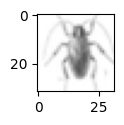

In [ ]:
_ = random.randint(0,len(data_train))
print(f"For picture #{_} - {label_train[_]}({superclass_dict[label_train[_]]}):")
fig = plt.figure(figsize=(1,1))
fig.add_subplot(1,1,1)
plt.imshow(data_train[_])
plt.show()

Трохи більше картинок з тренувальної та тестувальної вибірок...

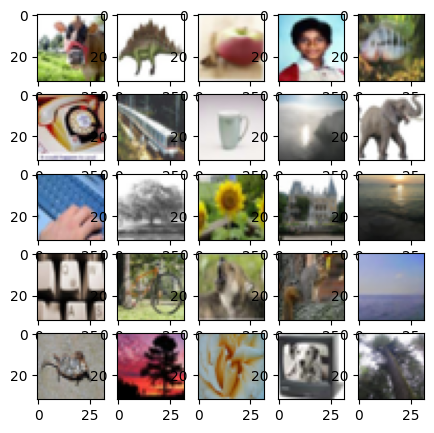

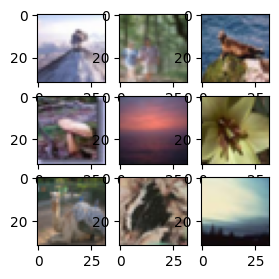

In [ ]:
def show_pictures_n_m(data,n,m:int):
    fig = plt.figure(figsize=(max(n,m),max(n,m)))
    for _ in range (n*m):
        fig.add_subplot(n,m,_+1)
        plt.imshow(data[_])
    plt.show()

show_pictures_n_m(data_train,5,5)
show_pictures_n_m(data_test,3,3)

## Подальша підготовка даних для тренувань мережі

In [ ]:
Також виконується приведення даних до типу float32
та нормалізація даних до діапазону наприклад [0, 1]
data_train = data_train.astype("float32")
data_test = data_test.astype("float32")
data_train = (data_train - 255)/ 255
data_test = (data_test - 255)/ 255

np.info(data_train)

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

169001437/169001437 [==============================] - 3s 0us/step


AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

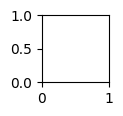

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Завантаження датасету CIFAR-100
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

# Нормалізація зображень
train_images = (train_images - 127.5) / 127.5
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)

# Генеративна мережа
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    return model

# Дискримінативна мережа
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Створення генератора і дискримінатора
generator = build_generator()
discriminator = build_discriminator()

# Втрата та оптимізатори
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Навчальний цикл
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch % 100 == 0:
            generate_and_save_images(generator, epoch, seed)

    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Підготовка датасету
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Запуск навчання
train(train_dataset, EPOCHS)


2. Архітектура Системи
# Генеративна Мережа

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model


# Дискримінативна Мережа

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


3. Процес Навчання
# Підготовка даних

In [ ]:
def preprocess_image(image):
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [32, 32])
    image = (image - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return image

def load_dataset(data_path):
    data = tf.keras.utils.get_file(data_path, origin=data_path)
    images = []  # List to store processed images
    for file in data:
        image = preprocess_image(tf.io.read_file(file))
        images.append(image)
    return tf.data.Dataset.from_tensor_slices(images).batch(32)


# Навчання моделі

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(f'Epoch {epoch+1} completed')


# 4. Інтерактивний Механізм Введення Зображення (Streamlit)

In [ ]:
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

# Попередньо збудовані моделі генератора і дискримінатора
generator = build_generator()
discriminator = build_discriminator()

# Завантаження збережених вагів (замініть шлях на фактичний)
generator.load_weights('generator_weights.h5')
discriminator.load_weights('discriminator_weights.h5')

def preprocess_image(image):
    image = np.array(image)
    image = tf.image.resize(image, [32, 32])
    image = (image - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return image

def main():
    st.title("CAPTCHA GAN: Генерація та Ідентифікація Зображень")

    uploaded_file = st.file_uploader("Завантажте зображення CAPTCHA", type=["png", "jpg", "jpeg"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption='Завантажене зображення', use_column_width=True)

        processed_image = preprocess_image(image)

        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)

        real_output = discriminator(tf.expand_dims(processed_image, axis=0), training=False)
        fake_output = discriminator(generated_image, training=False)

        verdict = "Справжнє" if real_output > fake_output else "Підроблене"

        st.write(f"Вердикт: {verdict}")

        st.image((generated_image[0] * 127.5 + 127.5).numpy().astype(np.uint8), caption='Згенероване зображення', use_column_width=True)

if __name__ == '__main__':
    main()



In [ ]:
!streamlit run Streamlitapp.py
